<div class="alert alert-info">
<h1>Bootstrapping (and Jackknifing)</h1>
<h4>Environmental Statistics 8</h4>
    
Ikedichi E. Azuh / C.F. Dormann
</div>

In today's session, we delve into bootstrapping and jackknifing techniques. Participants will learn how to implement bootstrapping to estimate uncertainty in model parameters. Additionally, we'll explore the distinction between quantifying uncertainty in model estimates versus uncertainty in model predictions, providing valuable insights into interpreting and utilizing these methods effectively in statistical analysis.fferentiating between quantifying uncertainty in model estimates (information about the model) and uncertainty in model predictions.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from multiprocessing import Pool, cpu_count
import time
from joblib import Parallel, delayed
import multiprocessing
import warnings

## 1 Exercise 1: Bootstrapping the standard error of a sample

### 1.1 Simulate a sample of 30 data points from a Poisson distribution with a mean ("lambda") of 2.2.

In [2]:
np.random.seed(123)
samp = np.random.poisson(lam=2.2, size=30)


### 1.2 Compute sample mean and standard error of the mean

In [3]:
print("Mean:", np.mean(samp))
print("Standard Error:", np.std(samp) / np.sqrt(len(samp)))


Mean: 2.5
Standard Error: 0.219848432637882


### 1.3 Use bootstrapping to compute mean and standard error of the mean

Bootstrapped mean: 2.496333333333333
Bootstrapped Standard Deviation: 0.22275522191160613


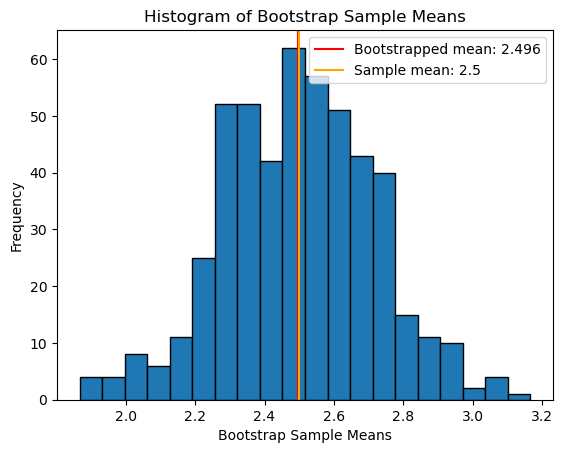

In [8]:
B = 500
bs = [] #np.empty(B)

np.random.seed(123)

for i in range(B):
    bootstrap_sample = np.random.choice(samp, size=len(samp), replace=True)
    mean_ = np.mean(bootstrap_sample)
    bs.append(mean_) # bs[i]

mean_bs = np.mean(bs)
sd_bs = np.std(bs)

print("Bootstrapped mean:", mean_bs)
print("Bootstrapped Standard Deviation:", sd_bs)

plt.hist(bs, bins=20, edgecolor='k')
plt.axvline(x=mean_bs, color="red", label="Bootstrapped mean: 2.496")
plt.axvline(x=np.mean(samp), color="orange", label="Sample mean: 2.5")
plt.xlabel("Bootstrap Sample Means")
plt.ylabel("Frequency")
plt.title("Histogram of Bootstrap Sample Means")
plt.legend()
plt.show()


So the mean and the standard error of this sample can be well-estimated by bootstrapping.


## 2 Exercise 2: Bootstrap GLM-estimates for Titanic analysis
Fit the following model: `glm(survived ~ (age + sex + passengerClass)^2, data=TitanicSurvival, family=binomial)`. Use bootstrapping to estimate standard errors for model estimates.

Hint: Do this in two steps. First, run the bootstraps and store *each* model in a long list. Second, extract the coefficient estimates from all these bootstrapped models (e.g. using `sapply`). This two-step approach allows us to extract other information later on, without having to re-run the bootstraps. (This is particularly important when models runs slowly and bootstrapping becomes computationally intensive.)

In [3]:
TitanicSurvival = pd.read_csv("TitanicSurvival.csv", 
                              dtype={"survived": "category", 
                                     "sex": "category", 
                                     "passengerClass": "category"})

model_list = []
np.random.seed(123)
B = 500

for i in range(B):
    sample_index = np.random.choice(TitanicSurvival.index, size=len(TitanicSurvival), replace=True)
    sampled_data = TitanicSurvival.loc[sample_index]
    formula = 'survived ~ (age + sex + passengerClass)**2'
    model = sm.formula.glm(formula=formula, data=sampled_data, family=sm.families.Binomial()).fit()
    model_list.append(model)

# Extract coefficients from the models
coefs = np.array([model.params for model in model_list])
coefs = pd.DataFrame(coefs, columns=model.params.index)

# Get the dimensions of the coefficients array
dimensions = coefs.shape
print("Dimensions of coefficients array:", dimensions)


Dimensions of coefficients array: (500, 10)


In [10]:
mean_std = coefs.agg(['mean', 'std'])
mean_std.T

,mean,std
Intercept,-3.633676,1.365229
sex[T.male],2.840777,1.259128
passengerClass[T.2nd],-0.649264,1.507941
passengerClass[T.3rd],3.514078,1.325816
sex[T.male]:passengerClass[T.2nd],0.762657,1.232855
sex[T.male]:passengerClass[T.3rd],-2.107291,1.140347
age,0.004777,0.020778
age:sex[T.male],0.030456,0.016319
age:passengerClass[T.2nd],0.062123,0.026662
age:passengerClass[T.3rd],0.005836,0.018816


In [11]:
# Alternatively:
print("Mean of coefficients Array: ")
print(np.mean(coefs, axis=0))
print('\n')
print("Standard deviation of coefficients Array: ")
print(np.std(coefs, axis=0))

Mean of coefficients Array: 
Intercept                           -3.633676
sex[T.male]                          2.840777
passengerClass[T.2nd]               -0.649264
passengerClass[T.3rd]                3.514078
sex[T.male]:passengerClass[T.2nd]    0.762657
sex[T.male]:passengerClass[T.3rd]   -2.107291
age                                  0.004777
age:sex[T.male]                      0.030456
age:passengerClass[T.2nd]            0.062123
age:passengerClass[T.3rd]            0.005836
dtype: float64


Standard deviation of coefficients Array: 
Intercept                            1.363863
sex[T.male]                          1.257868
passengerClass[T.2nd]                1.506432
passengerClass[T.3rd]                1.324489
sex[T.male]:passengerClass[T.2nd]    1.231621
sex[T.male]:passengerClass[T.3rd]    1.139206
age                                  0.020757
age:sex[T.male]                      0.016303
age:passengerClass[T.2nd]            0.026636
age:passengerClass[T.3rd]            

In [4]:
fti = sm.GLM.from_formula(formula, data=TitanicSurvival, family=sm.families.Binomial()).fit()
print(fti.summary())

                         Generalized Linear Model Regression Results                         
Dep. Variable:     ['survived[no]', 'survived[yes]']   No. Observations:                 1046
Model:                                           GLM   Df Residuals:                     1036
Model Family:                               Binomial   Df Model:                            9
Link Function:                                 Logit   Scale:                          1.0000
Method:                                         IRLS   Log-Likelihood:                -458.92
Date:                               Tue, 05 Dec 2023   Deviance:                       917.84
Time:                                       13:06:48   Pearson chi2:                 1.22e+03
No. Iterations:                                    6   Pseudo R-squ. (CS):             0.3781
Covariance Type:                           nonrobust                                         
                                        coef    std err     

### 2.1 Plot estimates of GLM against bootstrap estimates

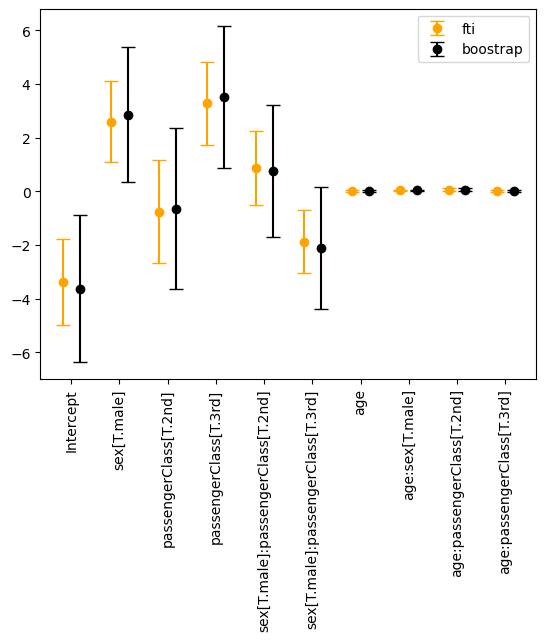

In [6]:
coefficients_fti = fti.params.values
sd_fti = fti.bse.values
mean_coefs = np.mean(coefs, axis=0)
sd_coefs = np.std(coefs, axis=0)

variable_names = fti.params.index

bar_width = 0.35
index = np.arange(len(variable_names))

#plt.bar(index - bar_width/2, coefficients_fti, bar_width, label='fti')
plt.errorbar(index - bar_width/2, coefficients_fti, yerr=2 * sd_fti, fmt='o', capsize=5, color ="orange", label='fti')

#plt.bar(index + bar_width/2, mean_coefs, bar_width, label='boostrap')
plt.errorbar(index + bar_width/2, mean_coefs, yerr=2 * sd_coefs, fmt='o', capsize=5, color = "black", label='boostrap')

plt.xticks(index, variable_names, rotation=90)
plt.legend()
plt.show()


## 3 Exercise 3: Bootstrapping indices
In plant competition experiments, one likes to quantify the effect of neighbours. One index to do so is the "relative neighbour index": $RNE = \frac{\bar{w}_\text{treat} - \bar{w}_\text{control}}{\max(\bar{w}_\text{treat}, \bar{w}_\text{control})}$. If the monoculture (= control) performs better than the mixture (= competition), the *RNE* is negative. A positive *RNE* indicates facilitation.

Since the *RNE* is computed using means across replicates, it does not have error bars. Now, equations for [propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae) can be employed to compute error bars in such situation, but they are relatively complicated for people not trained in calculus. Even for mathematically nimble persons, the maximum-function in the denominator is a headache.

So, instead, we'll use bootstrapping. First, we define the index as a function:

In [8]:
PlantGrowth = pd.read_csv("PlantGrowth.csv")

def RNE(treat, control):
    treat_mean = np.mean(treat)
    control_mean = np.mean(control)
    return (treat_mean - control_mean) / max(treat_mean, control_mean)

treat = PlantGrowth.loc[PlantGrowth['group'] == 'trt1', 'weight'].values
control = PlantGrowth.loc[PlantGrowth['group'] == 'ctrl', 'weight'].values

rne_value = RNE(treat, control)
print("Relative Net Effect (RNE):", rne_value)


Relative Net Effect (RNE): -0.07372813990461041


Now run a comparison of the `PlantGrowth` data set from the R **faraway** package (using control versus treatment 1). In the bootstrap, draw a random sample of the observed data and run the *RNE* with this bootstrap. Compute mean and 95\% confidence interval (i.e. 0.025 and 0.975 quantile of the bootstraps). 

Mean RNE (bootstrap): -0.07171414737696946
2.5th and 97.5th percentiles (bootstrap): [-0.16710129  0.03299423]


C:\Users\Ikedichi_Azuh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ikedichi_Azuh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


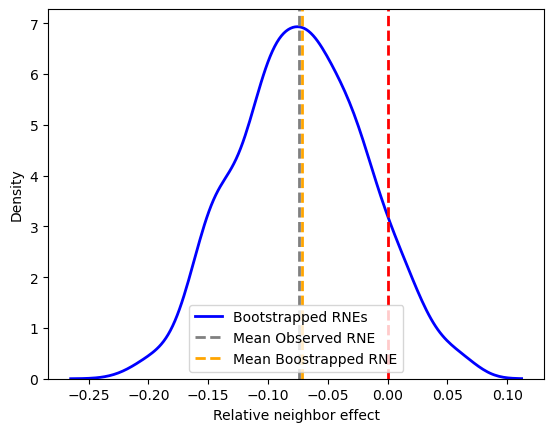

In [9]:
np.random.seed(1)

def RNE(treat, control):
    treat_mean = np.mean(treat)
    control_mean = np.mean(control)
    return (treat_mean - control_mean) / max(treat_mean, control_mean)

# Boostrap
B = 500
RNE_bs = np.empty(B)

for i in range(B):
    treat_bootstrap = np.random.choice(treat, size=len(treat), replace=True)
    control_bootstrap = np.random.choice(control, size=len(control), replace=True)
    RNE_bs[i] = RNE(treat_bootstrap, control_bootstrap)


mean_RNE_bs = np.mean(RNE_bs)
quantiles_RNE_bs = np.percentile(RNE_bs, [2.5, 97.5])

print("Mean RNE (bootstrap):", mean_RNE_bs)
print("2.5th and 97.5th percentiles (bootstrap):", quantiles_RNE_bs)

df = pd.DataFrame({'RNE_bs': RNE_bs})

sns.kdeplot(data=df, x='RNE_bs', color='blue', linewidth=2, label='Bootstrapped RNEs')
plt.axvline(RNE(treat, control), color='grey', linestyle='--', linewidth=2, label='Mean Observed RNE')
plt.axvline(mean_RNE_bs, color='orange', linestyle='--', linewidth=2, label='Mean Boostrapped RNE')
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Relative neighbor effect")
plt.ylabel("Density")
plt.legend()
plt.show()


## 4 Exercise 4: The jackknife
Bootstrapping yields a different estimate every time (unless we set the random seed). In contrast, if we omit each data point once, there is exactly one result of this kind of uncertainty analysis. When we use this to compute the effect on model coefficients (and their standard error), the procedure is called the "jackknife".

Note that the [variance of the jackknife](https://en.wikipedia.org/wiki/Jackknife_resampling) is **not** the usual $\frac{1}{n-1}\sum_{i=1}^n (x_i-\bar{x})^2$, but rather employs the "finite population correction" $FPC = \frac{N-n}{N-1}$, which is multiplied onto the estimate of the variance. The point is that our population is only the number of jackknifes (or data points) $N$, and not an infinite size as in the bootstrap. Hence we need to correct the computed variance for the fact that we have sampled a large proportion of the total data (namely all but one: $n=N-1$). Put into the equation for the *standard deviation* of the jackknifed estimates, we get $\sqrt{\frac{N-1}{N}\sum_{i=1}^N (x_i-\bar{x})^2}$.

In [12]:
warnings.filterwarnings('ignore') # this is to surpress warining
##############################################################


#load data
mammalsleep = pd.read_csv("mammalsleep.csv")


# Remove NANs
mammalsleep = mammalsleep.dropna()
N = len(mammalsleep)

coef_mat = np.empty((N, 4))
RMSE = np.empty(N)

for i in range(N):
    fmcv = sm.OLS.from_formula('sleep ~ np.log10(body) * np.log10(lifespan)',
                               data=mammalsleep.drop(mammalsleep.index[i])).fit()
    
    coef_mat[i, :] = fmcv.params.values
    predscv = fmcv.predict(sm.add_constant(np.log10(mammalsleep[['body', 'lifespan']]).iloc[[i]]))
    RMSE[i] = np.sqrt(np.mean((mammalsleep['sleep'].iloc[i] - predscv)**2))
    del fmcv, predscv

# Jackknife statistics
jackMean = np.mean(coef_mat, axis=0)
Nreal = len(RMSE[~np.isnan(RMSE)])
jackSD = np.sqrt((Nreal - 1) / Nreal * np.sum((coef_mat[~np.isnan(RMSE), :] - jackMean)**2, axis=0))

print('Jackknife mean:', np.round(jackMean, 3))
print('Jackknife standard deviation:', np.round(jackSD, 4))
print('\n')


model_summary = sm.OLS(mammalsleep['sleep'], sm.add_constant(np.log10(mammalsleep[['body', 'lifespan']]))).fit()
print(model_summary.summary())


Jackknife mean: [11.221  0.427  0.907 -2.179]
Jackknife standard deviation: [2.5703 1.5952 1.9844 0.9815]


                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     12.14
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           7.98e-05
Time:                        13:11:11   Log-Likelihood:                -114.01
No. Observations:                  42   AIC:                             234.0
Df Residuals:                      39   BIC:                             239.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

Deviation between jackknife and linear model can be attributed to effect of small-sample deviation from asymptotic assumptions of the linear model.




## 4 Bonus Code: Parallelisation
Since things can take a while with bootstrapping, here's a hint on how to speed it up using all your computer's cores, rather than only 1.

### 4.1 clusterApply

In [12]:
predictTo = pd.DataFrame(mammalsleep.mean(axis=0)).T

def bsfun(_):
    sampled_data = mammalsleep.sample(n=len(mammalsleep), replace=True)
    # Fit regression tree
    fr = DecisionTreeRegressor()
    fr.fit(sampled_data.drop('sleep', axis=1), sampled_data['sleep'])
    predictions = fr.predict(predictTo.drop('sleep', axis=1))
    return predictions

if __name__ == '__main__':
    # lapply
    lapply_results = [bsfun(_) for _ in range(5)]
    for i, result in enumerate(lapply_results, 1):
        print(f"lapply Result {i}:\n{result}\n")
    
    # CPU cores
    nCores = cpu_count()
    pool = Pool(processes=nCores - 1)  # Keep one core for other tasks
    
    # mclapply
    mclapply_results = pool.map(bsfun, range(1000))
    pool.close()
    pool.join()

    result_df = pd.DataFrame(mclapply_results, columns=['Predicted'])
    print(result_df.describe())


lapply Result 1:
[9.8]

lapply Result 2:
[10.7]

lapply Result 3:
[10.3]

lapply Result 4:
[10.7]

lapply Result 5:
[9.1]

         Predicted
count  1000.000000
mean      9.689500
std       0.756712
min       8.000000
25%       9.600000
50%       9.700000
75%       9.800000
max      13.700000


In [13]:
pred_bs = np.ones(1000)

start_time = time.time()

for i in range(1000):
    sampled_data = mammalsleep.sample(n=len(mammalsleep), replace=True)
    fcart = DecisionTreeRegressor()
    fcart.fit(sampled_data.drop('sleep', axis=1), sampled_data['sleep'])
    pred_bs[i] = fcart.predict(predictTo.drop('sleep', axis=1))

end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


Elapsed time: 28.707818269729614 seconds


### 4.2 foreach

In [14]:
nCores = multiprocessing.cpu_count()

start_time = time.time()    
Parallel(n_jobs=nCores - 1)(delayed(bsfun)(i) for i in range(1000))

rpartBSforeach = Parallel(n_jobs=nCores - 1)(delayed(bsfun)(i) for i in range(1000))
end_time = time.time()
elapsed_time = end_time - start_time

result_df = pd.DataFrame(rpartBSforeach, columns=['Predicted'])

print(f"Elapsed time: {elapsed_time} seconds")
print(result_df.describe())


Elapsed time: 25.16209840774536 seconds
         Predicted
count  1000.000000
mean      9.629500
std       0.788112
min       3.800000
25%       9.600000
50%       9.700000
75%       9.800000
max      10.900000


In this case, with the parallel version the elapsed time is shorter. Add time.sleep(3) to all three methods to compare.